In [1]:
test_id = 'ST_wider_cycle_BNGN_FINAL'

# wandb setup

In [ ]:
!pip install wandb

## Wandb Key 입력

사용자 wandb api key를 입력

In [ ]:
import wandb

wandb.login(key='')

## Wandb 프로젝트 생성

wandb.init(project="project-name", entity="user-name")

project 이름과 user name 입력

In [ ]:
wandb.init(project="SaumsungSEM", entity="")
wandb.run.name = test_id

# Basic Setup

In [5]:
import random
import pandas as pd
import numpy as np
import os
import glob
import cv2
import zipfile

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader
import itertools

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from datetime import datetime

import warnings
warnings.filterwarnings(action='ignore') 

In [6]:
CFG = {
    #################################################
    'DEBUG': False,
    'OPEN_ZIP_PATH': './open.zip',
    'PROJECT_DIR': './cycle',
    #################################################


    #기본 설정
    'RUN_TYPE': 'ST',                 #ST / TD / Clf
    'TRAIN_CASE': 1,                  #1 / 2 / 3 / 4
    'SAVE_EPOCH_TERM': 2,

    #모델 설정
    'STG_RES_NUM': 2,
    'STG_DIM': 64,
    'STG_PATHS':[],
    'STD_DIM': 64,
    'STD_PATHS':[],
    'STD_DROPOUT': 0.3,

    #학습 parameter 설정
    'EPOCHS': 300,
    'BATCH_SIZE': 128,
    'LAMBDA_IDT': 0.5,
    'LAMBDA_CYCLE': 10,
    'GAN_LR': 0.0002,

    #기타
    'PERCENTILES': [0, 0.01, 0.03, 0.05, 0.07 ,0.1, 0.15, 0.2, 0.2, 0.3, 0.35, 0.38, 0.4, 0.42, 0.44, 0.46, 0.48, 0.5, 0.6, 0.7, 0.8],
    'SEED': 42,
}
CFG['IMG_dir'] = f'{CFG["PROJECT_DIR"]}/{test_id}/images/{CFG["TRAIN_CASE"]}'
CFG['STG_dir'] = f'{CFG["PROJECT_DIR"]}/{test_id}/STG/{CFG["TRAIN_CASE"]}'
CFG['STD_dir'] = f'{CFG["PROJECT_DIR"]}/{test_id}/STD/{CFG["TRAIN_CASE"]}'

os.makedirs(CFG['IMG_dir'], exist_ok=True)
os.makedirs(CFG['STG_dir'], exist_ok=True)
os.makedirs(CFG['STD_dir'], exist_ok=True)

wandb.config.update(CFG)

In [7]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

In [8]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Prepare Dataset

In [10]:
if CFG['OPEN_ZIP_PATH'] is not None:
  with zipfile.ZipFile(CFG['OPEN_ZIP_PATH']) as z:
    z.extractall()

In [11]:
simulation_sem_path = sorted(glob.glob('./simulation_data/SEM/*/*/*.png'))
simulation_depth_paths = sorted(glob.glob('./simulation_data/Depth/*/*/*.png'))
simulation_sem_paths = np.array(simulation_sem_path).reshape(-1,2)

df_simul = pd.DataFrame({'iter0':simulation_sem_paths[:,0], 'iter1':simulation_sem_paths[:,1], 'depth':simulation_depth_paths})
df_simul['case'] = df_simul['iter0'].apply(lambda x: int(x[27]))
df_simul.head()

,iter0,iter1,depth,case
0,./simulation_data/SEM\Case_1\80\20201001_20294...,./simulation_data/SEM\Case_1\80\20201001_20294...,./simulation_data/Depth\Case_1\80\20201001_202...,1
1,./simulation_data/SEM\Case_1\80\20201001_20294...,./simulation_data/SEM\Case_1\80\20201001_20294...,./simulation_data/Depth\Case_1\80\20201001_202...,1
2,./simulation_data/SEM\Case_1\80\20201001_20294...,./simulation_data/SEM\Case_1\80\20201001_20294...,./simulation_data/Depth\Case_1\80\20201001_202...,1
3,./simulation_data/SEM\Case_1\80\20201001_20294...,./simulation_data/SEM\Case_1\80\20201001_20294...,./simulation_data/Depth\Case_1\80\20201001_202...,1
4,./simulation_data/SEM\Case_1\80\20201001_20294...,./simulation_data/SEM\Case_1\80\20201001_20294...,./simulation_data/Depth\Case_1\80\20201001_202...,1


In [12]:
len(df_simul)

86652

In [13]:
train_data_path = glob.glob('./train/SEM/*/*/*.png')

df_train = pd.DataFrame({'path':train_data_path})
df_train['case'] = df_train['path'].apply(lambda x: int(x[18:21])//10%10)
df_train.head()

,path,case
0,./train/SEM\Depth_110\site_00000\SEM_043510.png,1
1,./train/SEM\Depth_110\site_00000\SEM_043987.png,1
2,./train/SEM\Depth_110\site_00000\SEM_045397.png,1
3,./train/SEM\Depth_110\site_00000\SEM_046894.png,1
4,./train/SEM\Depth_110\site_00000\SEM_049394.png,1


# ST_Dataset

In [14]:
class ST_Simul_Dataset(Dataset):  
  def __init__(self, df):
    self.df = df
  def __len__(self):
    return len(self.df)
  def __getitem__(self, idx):
    sem1 = torch.Tensor(cv2.imread(self.df.iloc[idx,0], cv2.IMREAD_GRAYSCALE))[None, :]
    sem2 = torch.Tensor(cv2.imread(self.df.iloc[idx,1], cv2.IMREAD_GRAYSCALE))[None, :]
    sem = (sem1 + sem2) / 212 - 1    

    return sem 

class ST_Train_Dataset(Dataset):
  def __init__(self, df):
    self.df = df
  def __len__(self):
    return len(self.df)
  def __getitem__(self, idx):
    train = torch.Tensor(cv2.imread(self.df.iloc[idx,0], cv2.IMREAD_GRAYSCALE))[None,:]

    return train / 212 * 2 - 1

# Extra Class & Functions

In [15]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv2d") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

# WGAN


In [16]:
class Resblock(nn.Module):
  def __init__(self, dim):
    super(Resblock, self).__init__()
    self.main = nn.Sequential(
      nn.Conv2d(dim, dim, 3, 1, 1, padding_mode='replicate'),
      nn.BatchNorm2d(dim),
      nn.ReLU(),

      nn.Conv2d(dim, dim, 3, 1, 1, padding_mode='replicate'),
      nn.BatchNorm2d(dim),
    )
  
  def forward(self, img):
    return img + self.main(img)

In [17]:
import torch.nn.functional as F
from torch.autograd import Variable
from torch.autograd import Variable
from torch.autograd import grad as torch_grad

class Generator(nn.Module):
    def __init__(self, dim):
        super(Generator, self).__init__() 
        self.encoder = nn.Sequential(
            nn.Conv2d(1, dim, 7, 1, padding='same', padding_mode='replicate'),
            nn.BatchNorm2d(dim),
            nn.ReLU(),
            nn.Conv2d(dim, 2*dim, 4, 2, 1, padding_mode='replicate'),
            nn.BatchNorm2d(2*dim),
            nn.ReLU(),
        )
        resblocks = [Resblock(2*dim) for _ in range(CFG['STG_RES_NUM'])]
        self.middle_layer = nn.Sequential(*resblocks)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(2 * dim, dim, 4, 2, 1),
            nn.BatchNorm2d(dim),
            nn.ReLU(),
            nn.Conv2d(dim, 1, 7, 1, padding='same', padding_mode='replicate'),
            nn.Tanh()
        )

    def forward(self, simul_sem):
        weights = self.encoder(simul_sem)
        weights = self.middle_layer(weights)
        weights = self.decoder(weights)
        return weights


class Discriminator(nn.Module):
    def __init__(self, dim):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(1, dim, 7, 1, padding='same', padding_mode='replicate'),
            nn.LeakyReLU(0.2),

            nn.Conv2d(dim, dim, 4, 2, 1),           #(Batch, dim, 36, 24)
            nn.GroupNorm(4, dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(p=CFG['STD_DROPOUT']),

            nn.Conv2d(dim, dim, 3, 1, 1),   
            nn.GroupNorm(4, dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(p=CFG['STD_DROPOUT']),

            nn.Conv2d(dim, 2 * dim, 4, 2, 1),     #(Batch, 2*dim, 18, 12)
            nn.GroupNorm(4, 2*dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(p=CFG['STD_DROPOUT']),

            nn.Conv2d(2*dim, 2*dim, 3, 1, 1),
            nn.GroupNorm(4, 2*dim),
            nn.LeakyReLU(2*dim),
            nn.Dropout(p=CFG['STD_DROPOUT']),

            nn.Conv2d(2 * dim, 4 * dim, 4, 2, 1), #(Batch, 4*dim, 9, 6)
            nn.GroupNorm(4, 4*dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(p=CFG['STD_DROPOUT']),

            nn.Conv2d(4*dim, 4*dim, 3, 1, 1),
            nn.GroupNorm(4, 4*dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(p=CFG['STD_DROPOUT']),

            nn.Conv2d(4*dim, 1, (9,6), 1, 1)
        )

    def forward(self, trasnfered_SEM):
        x = self.main(trasnfered_SEM)
        return x

# Trainer

In [18]:
class Trainer():
  def __init__(self, generator, discriminator, device=device, model_checkpoint=None,
               lambda_idt=CFG['LAMBDA_IDT'], lambda_cycle=CFG['LAMBDA_CYCLE'], lambda_GP=10, critic_iterations=5):
      self.G_ST = generator(dim=CFG['STG_DIM']).to(device)
      self.G_TS = generator(dim=CFG['STG_DIM']).to(device)
      self.G_opt = torch.optim.Adam(itertools.chain(self.G_ST.parameters(), self.G_TS.parameters()),lr=CFG['GAN_LR'], betas=(0.5,0.999))

      self.D_T = discriminator(dim=CFG['STG_DIM']).to(device)
      self.D_S = discriminator(dim=CFG['STG_DIM']).to(device)
      self.D_T_opt = torch.optim.Adam(params=self.D_T.parameters(), lr=CFG['GAN_LR'], betas=(0.5,0.999))
      self.D_S_opt = torch.optim.Adam(params=self.D_S.parameters(), lr=CFG['GAN_LR'], betas=(0.5,0.999))
        
      self.scheduler_D_T = optim.lr_scheduler.MultiStepLR(self.D_T_opt, milestones=[100, 200, 300], gamma=0.5, verbose=True)
      self.scheduler_D_S = optim.lr_scheduler.MultiStepLR(self.D_S_opt, milestones=[100, 200, 300], gamma=0.5, verbose=True)
      self.scheduler_G = optim.lr_scheduler.MultiStepLR(self.G_opt, milestones=[100, 200, 300], gamma=0.5, verbose=True)
        
    
      if model_checkpoint is None:
          weights_init_normal(self.G_ST)
          weights_init_normal(self.G_TS)
          weights_init_normal(self.D_T)
          weights_init_normal(self.D_S)
          self.last_epoch = 0
      
      else:
          self.last_epoch = model_checkpoint['last_epoch']
          self.G_ST.load_state_dict(torch.load(model_checkpoint['G_ST']))
          self.G_TS.load_state_dict(torch.load(model_checkpoint['G_TS']))            
          self.D_T.load_state_dict(torch.load(model_checkpoint['D_T']))
          self.D_S.load_state_dict(torch.load(model_checkpoint['D_S']))

          try:
            self.G_opt.load_state_dict(torch.load(model_checkpoint['G_opt']))
            self.scheduler_G.load_state_dict(torch.load(model_checkpoint['scheduler_G']))
            self.D_T_opt.load_state_dict(torch.load(model_checkpoint['D_T_opt']))
            self.D_S_opt.load_state_dict(torch.load(model_checkpoint['D_S_opt']))
            self.scheduler_D_T.load_state_dict(torch.load(model_checkpoint['scheduler_D_T']))
            self.scheduler_D_S.load_state_dict(torch.load(model_checkpoint['scheduler_D_S']))
          except KeyError:
            print('load model only')
          print('train checkpoint loaded')

      wandb.watch(self.G_ST)
      wandb.watch(self.G_TS)
      wandb.watch(self.D_T)
      wandb.watch(self.D_S)
  
      self.criterion_idt = nn.L1Loss()
      self.criterion_cycle = nn.L1Loss()

      self.log = {'G':[], 'D_S': [], 'D_T': [], 'GP': [], 'gradient_norm': [],
                     'cycle_ST': [], 'cycle_TS': [],  'IDT_TS':[], 'IDT_ST':[],
                     'D_S': [], 'D_T': [],'D_S_fake':[], 'D_S_real':[], 'D_T_fake':[], 'D_T_real':[]}
      self.num_steps = 0

      self.lambda_idt = lambda_idt
      self.lambda_GP = lambda_GP
      self.lambda_cycle = lambda_cycle
      self.critic_iterations = critic_iterations

      self.device = device
  def _critic_train_iteration(self, simul_SEM, train_SEM):
      #Generate Image S
      fake_ST = self.G_ST(simul_SEM)
      #Generate Image T
      fake_TS = self.G_TS(train_SEM)

      #Discriminator S
      d_S_real = self.D_S(simul_SEM)
      d_S_fake = self.D_S(fake_TS)

      #Discriminator T
      d_T_real = self.D_T(train_SEM)
      d_T_fake = self.D_T(fake_ST)

      # Get gradient penalty for S
      gradient_penalty_S = self._gradient_penalty(self.D_S, simul_SEM, fake_TS)
      self.log['GP'].append(gradient_penalty_S.item())

      # Get gradient penalty for T
      gradient_penalty_T = self._gradient_penalty(self.D_T, train_SEM, fake_ST)
      self.log['GP'].append(gradient_penalty_T.item())
   
      # weight update S
      self.D_S_opt.zero_grad()
      d_S_loss = d_S_fake.mean() - d_S_real.mean() + gradient_penalty_S
      d_S_loss.backward()
      self.D_S_opt.step()

      # weight update T
      self.D_T_opt.zero_grad()
      d_T_loss = d_T_fake.mean() - d_T_real.mean() + gradient_penalty_T
      d_T_loss.backward()
      self.D_T_opt.step()

      # Record loss
      self.log['D_S'].append(d_S_loss.item())
      self.log['D_T'].append(d_T_loss.item())
      self.log['D_S_fake'].append(d_S_fake.mean().item())
      self.log['D_S_real'].append(d_S_real.mean().item())
      self.log['D_T_fake'].append(d_T_fake.mean().item())
      self.log['D_T_real'].append(d_T_real.mean().item())

  def _generator_train_iteration(self, simul_SEM, train_SEM, epoch):
      #Generate Image ST
      fake_ST = self.G_ST(simul_SEM)
      #Generate Iamge TS
      fake_TS = self.G_TS(train_SEM)
      self.G_opt.zero_grad()

      # Calculate loss and optimize
  
      #IDT Loss ST
      ST_idt_loss = self.criterion_idt(simul_SEM, fake_ST) * self.lambda_idt
      #IDT Loss TS
      TS_idt_loss = self.criterion_idt(train_SEM, fake_TS) * self.lambda_idt

      #GAN_Loss ST
      d_T_fake = self.D_T(fake_ST)
      #GAN_Loss TS
      d_S_fake = self.D_S(fake_TS)

      #get cycle_loss ST
      rec_S = self.G_TS(fake_ST)
      loss_cycle_S = self.criterion_cycle(rec_S, simul_SEM) * self.lambda_cycle
      #get cycle_loss TS
      rec_T = self.G_ST(fake_TS)
      loss_cycle_T = self.criterion_cycle(rec_T, train_SEM) * self.lambda_cycle

      loss_G = -d_T_fake.mean() - d_S_fake.mean() + ST_idt_loss + TS_idt_loss + loss_cycle_S + loss_cycle_T
      loss_G.backward()
      self.G_opt.step()

      if self.num_steps % 500 == 0:
        img_sample = torch.cat((simul_SEM.data[0], fake_ST.data[0], rec_S.data[0], train_SEM.data[0], fake_TS.data[0], rec_T.data[0]), -2)
        img_sample = (img_sample + 1) * 212 / 2
        img_sample = img_sample.view(1,-1,48).cpu().numpy().transpose(1,2,0)
        cv2.imwrite(f'{CFG["IMG_dir"]}/{str(epoch).zfill(4)}.png', img_sample)
      # Record loss
      self.log['G'].append(loss_G.item())
      self.log['IDT_ST'].append(ST_idt_loss.item())
      self.log['IDT_TS'].append(TS_idt_loss.item())
      self.log['cycle_ST'].append(loss_cycle_S.item())
      self.log['cycle_TS'].append(loss_cycle_T.item())

  def _gradient_penalty(self, netD, SEM, fake_SEM):
    b_size = SEM.size()[0]

    # Calculate interpolation
    alpha = torch.rand(b_size, 1, 1, 1)
    alpha = alpha.expand_as(SEM)
    alpha = alpha.cuda()

    interpolated = alpha * SEM.data + (1 - alpha) * fake_SEM.data
    interpolated = Variable(interpolated, requires_grad=True)
    interpolated = interpolated.cuda()

    # Calculate probability of interpolated examples
    prob_interpolated = netD(interpolated)

    # Calculate gradients of probabilities with respect to examples
    gradients = torch_grad(outputs=prob_interpolated, inputs=interpolated,
                          grad_outputs=torch.ones(prob_interpolated.size()).cuda(),
                          create_graph=True, retain_graph=True)[0]

    # Gradients have shape (batch_size, num_channels, img_width, img_height),
    # so flatten to easily take norm per example in batch
    gradients = gradients.view(b_size, -1)
    self.log['gradient_norm'].append(gradients.norm(2, dim=1).mean().item())
    # Derivatives of the gradient close to 0 can cause problems because of
    # the square root, so manually calculate norm and add epsilon
    gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)

    # Return gradient penalty
    return self.lambda_GP * ((gradients_norm - 1) ** 2).mean()

  def _train_epoch(self, simul_loader, train_loader, epoch):
      for i, simul_SEM in enumerate(tqdm(simul_loader)):
        try:
          train_SEM = next(self.train_iter)
          assert train_SEM.shape[0] == simul_SEM.shape[0]
        except (AssertionError, StopIteration):
          if train_SEM.shape[0] > simul_SEM.shape[0]:
            train_SEM = train_SEM[:simul_SEM.shape[0]]
          else:
            self.train_iter = iter(train_loader)
            train_SEM = next(self.train_iter)[:simul_SEM.shape[0]]
        simul_SEM = simul_SEM.to(self.device)
        train_SEM = train_SEM.to(self.device)

        self.num_steps += 1
        self._critic_train_iteration(simul_SEM, train_SEM)
        # Only update generator every |critic_iterations| iterations
        if self.num_steps % self.critic_iterations == 0:
            self._generator_train_iteration(simul_SEM, train_SEM, epoch)
        
  def train(self, simul_loader, train_loader, epochs, save_every):
      df_train = self.get_df(None, train_loader)
      df_simul = self.get_df(None, simul_loader)
      self.train_iter = iter(train_loader)
      for epoch in range(self.last_epoch, epochs):
          print("\nEpoch {}\n".format(epoch + 1))
          self._train_epoch(simul_loader, train_loader, epoch)
          log = self.get_log(epoch)
          if (epoch > CFG['EPOCHS']-10 and epoch % save_every == 0) or (epoch % 20 == 0):
            self.model_save(epoch)
            print('################Model Saved################')

            self.G_ST.eval()
            self.G_TS.eval()
            with torch.no_grad():
              print('Generating plot for wandb...')
              df_simul_for_plot = self.get_df(self.G_ST, simul_loader)
              log = self.get_plot(df_train, df_simul_for_plot,Gtype='ST', log=log)
              df_train_for_plot = self.get_df(self.G_TS, train_loader)
              log = self.get_plot(df_simul, df_train_for_plot,Gtype='TS', log=log)
              print('Pushing plot Finished')

          self.G_ST.train()
          self.G_TS.train()
          wandb.log(log)
          if self.scheduler_G is not None:
            self.scheduler_G.step()
          if self.scheduler_D_S is not None:
            self.scheduler_D_S.step()
          if self.scheduler_D_T is not None:
            self.scheduler_D_T.step()

  def model_save(self, epoch):
    torch.save(self.G_opt.state_dict(), f'{CFG["STG_dir"]}/optG_{str(epoch+1).zfill(3)}.pth')
    torch.save(self.G_ST.state_dict(), f'{CFG["STG_dir"]}/G_ST_{str(epoch+1).zfill(3)}.pth')
    torch.save(self.G_TS.state_dict(), f'{CFG["STG_dir"]}/G_TS_{str(epoch+1).zfill(3)}.pth')
    torch.save(self.scheduler_G.state_dict(), f'{CFG["STG_dir"]}/schedlerG_{str(epoch+1).zfill(3)}.pth')

    torch.save(self.D_S_opt.state_dict(), f'{CFG["STD_dir"]}/optD_S{str(epoch+1).zfill(3)}.pth')
    torch.save(self.D_S.state_dict(), f'{CFG["STD_dir"]}/STD_S{str(epoch+1).zfill(3)}.pth')
    torch.save(self.scheduler_D_S.state_dict(), f'{CFG["STD_dir"]}/schedlerD_S{str(epoch+1).zfill(3)}.pth')

    torch.save(self.D_T_opt.state_dict(), f'{CFG["STD_dir"]}/optD_T{str(epoch+1).zfill(3)}.pth')
    torch.save(self.D_T.state_dict(), f'{CFG["STD_dir"]}/STD_T{str(epoch+1).zfill(3)}.pth')
    torch.save(self.scheduler_D_T.state_dict(), f'{CFG["STD_dir"]}/schedlerD_T{str(epoch+1).zfill(3)}.pth')

  def get_log(self, epoch):
    G_losses = np.mean(self.log['G'])
    IDT_ST_losses = np.mean(self.log['IDT_ST'])
    IDT_TS_losses = np.mean(self.log['IDT_TS'])
    D_S_losses = np.mean(self.log['D_S'])
    D_T_losses = np.mean(self.log['D_T'])
    GP_losses = np.mean(self.log['GP'])
    gradient_norm = np.mean(self.log['gradient_norm'])
    D_S_fake = np.mean(self.log['D_S_fake'])
    D_S_real = np.mean(self.log['D_S_real'])
    D_T_fake = np.mean(self.log['D_T_fake'])
    D_T_real = np.mean(self.log['D_T_real'])
    cycle_ST = np.mean(self.log['cycle_ST'])
    cycle_TS = np.mean(self.log['cycle_TS'])

    log = {'epoch': epoch,
            f'G_loss_{CFG["TRAIN_CASE"]}': G_losses,
            f'IDT_ST_losses{CFG["TRAIN_CASE"]}': IDT_ST_losses,
            f'IDT_TS_losses{CFG["TRAIN_CASE"]}': IDT_TS_losses,
            f'D_S_losses_{CFG["TRAIN_CASE"]}': D_S_losses,
            f'D_T_losses_{CFG["TRAIN_CASE"]}': D_T_losses,
            f'GP_losses_{CFG["TRAIN_CASE"]}': GP_losses,
            f'gradient_norm_{CFG["TRAIN_CASE"]}': gradient_norm,
            f'D_S_fake_{CFG["TRAIN_CASE"]}' : D_S_fake,
            f'D_S_real_{CFG["TRAIN_CASE"]}' : D_S_real,
            f'D_T_fake_{CFG["TRAIN_CASE"]}' : D_T_fake,
            f'D_T_real_{CFG["TRAIN_CASE"]}' : D_T_real,
            f'cycle_ST_{CFG["TRAIN_CASE"]}' : cycle_ST,
            f'cycle_TS_{CFG["TRAIN_CASE"]}' : cycle_TS,
            }
    self.log = {'G':[], 'D_S': [], 'D_T': [], 'GP': [], 'gradient_norm': [],
                'cycle_ST': [], 'cycle_TS': [],  'IDT_TS':[], 'IDT_ST':[],
                'D_S': [], 'D_T': [],'D_S_fake':[], 'D_S_real':[], 'D_T_fake':[], 'D_T_real':[]}
    return log

  def get_df(self, model, loader):
    avg = torch.Tensor([]).to(self.device)
    std = torch.Tensor([]).to(self.device)
    percentiles = torch.Tensor(CFG['PERCENTILES']).to(self.device)
    p = torch.zeros(1, len(percentiles)).to(self.device)
    #EDA 파일과 같은 방식으로 각 데이터 수집
    for img in tqdm(loader):
      img = img.to(self.device)
      if model is not None:
        img = model(img)

      img = img.view(-1,3456).detach()
      avg = torch.cat((avg, torch.mean(img, dim=1)))
      std = torch.cat((std, torch.std(img, dim=1, unbiased=False)))
      temp = torch.quantile(img, percentiles, dim=1, interpolation='nearest')
      temp = torch.transpose(temp, 1, 0)
      p = torch.cat((p, temp.detach()))

    avg = avg.cpu()
    std = std.cpu()
    p = p[1:].cpu()
    percentiles = percentiles.cpu().numpy()
    df = pd.DataFrame({'avg': avg, 'std': std})
    for i in range(len(percentiles)):
      df[str(percentiles[i])[1:]+'%'] = p[:,i]
    return df

  #wandb 전송할 plot 생성
  def get_plot(self, df1, df2, Gtype, log):
    case=CFG['TRAIN_CASE']
    percentiles = CFG['PERCENTILES']
    fig, axes = plt.subplots(nrows=(len(percentiles)+2)//2, ncols=2)
    fig.set_size_inches(30, 4 *len(axes))

    key = iter(df1.keys())
    for rows in axes:
      for ax in rows:
        try:
          target = next(key)
          ax1 = ax.twinx()
          sns.histplot(data=df1, x=target, kde=False, ax=ax, palette='bright')
          sns.kdeplot(data=df2, x=target, ax=ax1, palette='bright')

        except StopIteration:
          break 
    log[f'Analysis_{Gtype}_{CFG["TRAIN_CASE"]}'] = wandb.Image(fig)
    plt.cla()
    plt.clf()
    plt.close('all')
    return log

# Train 1


In [23]:
CFG['TRAIN_CASE'] = 1
CFG['IMG_dir'] = f'{CFG["PROJECT_DIR"]}/{test_id}/images/{CFG["TRAIN_CASE"]}'
CFG['STG_dir'] = f'{CFG["PROJECT_DIR"]}/{test_id}/STG/{CFG["TRAIN_CASE"]}'
CFG['STD_dir'] = f'{CFG["PROJECT_DIR"]}/{test_id}/STD/{CFG["TRAIN_CASE"]}'

os.makedirs(CFG['IMG_dir'], exist_ok=True)
os.makedirs(CFG['STG_dir'], exist_ok=True)
os.makedirs(CFG['STD_dir'], exist_ok=True)

model_checkpoint = None
wandb.config.update(CFG)

In [24]:
#dataset 준비
seed_everything(CFG['SEED']) # Seed 고정

temp_simul = df_simul[df_simul['case'] == CFG['TRAIN_CASE']]
temp_train = df_train[df_train['case']==CFG['TRAIN_CASE']]
if CFG['DEBUG'] == True:
  temp_simul = temp_simul.iloc[:1000]
  temp_train = temp_train.iloc[:800]

ST_simul = ST_Simul_Dataset(temp_simul)
ST_train = ST_Train_Dataset(temp_train)


ST_simul_loader = DataLoader(ST_simul, batch_size=CFG['BATCH_SIZE'], shuffle=True)
ST_train_loader = DataLoader(ST_train, batch_size=CFG['BATCH_SIZE'], shuffle=True)

wgan_trainer = Trainer(Generator, Discriminator, device, model_checkpoint = model_checkpoint)

Adjusting learning rate of group 0 to 2.0000e-04.
Adjusting learning rate of group 0 to 2.0000e-04.
Adjusting learning rate of group 0 to 2.0000e-04.


In [ ]:
wgan_trainer.train(ST_simul_loader, ST_train_loader, CFG['EPOCHS'], 2)

# Train 2


In [31]:
CFG['TRAIN_CASE'] = 2
CFG['IMG_dir'] = f'{CFG["PROJECT_DIR"]}/{test_id}/images/{CFG["TRAIN_CASE"]}'
CFG['STG_dir'] = f'{CFG["PROJECT_DIR"]}/{test_id}/STG/{CFG["TRAIN_CASE"]}'
CFG['STD_dir'] = f'{CFG["PROJECT_DIR"]}/{test_id}/STD/{CFG["TRAIN_CASE"]}'

os.makedirs(CFG['IMG_dir'], exist_ok=True)
os.makedirs(CFG['STG_dir'], exist_ok=True)
os.makedirs(CFG['STD_dir'], exist_ok=True)

model_checkpoint = {}
model_checkpoint['last_epoch'] = 0
model_checkpoint['G_ST'] = f'{CFG["PROJECT_DIR"]}/{test_id}/STG/1/G_ST_299.pth'
model_checkpoint['G_TS'] = f'{CFG["PROJECT_DIR"]}/{test_id}/STG/1/G_TS_299.pth'       
model_checkpoint['D_T'] = f'{CFG["PROJECT_DIR"]}/{test_id}/STD/1/STD_T299.pth' 
model_checkpoint['D_S'] = f'{CFG["PROJECT_DIR"]}/{test_id}/STD/1/STD_S299.pth' 
CFG['EPOCHS'] = 100

wandb.config.update(CFG)

In [32]:
#dataset 준비
seed_everything(CFG['SEED']) # Seed 고정

temp_simul = df_simul[df_simul['case'] == CFG['TRAIN_CASE']]
temp_train = df_train[df_train['case']==CFG['TRAIN_CASE']]
if CFG['DEBUG'] == True:
  temp_simul = temp_simul.iloc[:1000]
  temp_train = temp_train.iloc[:800]

ST_simul = ST_Simul_Dataset(temp_simul)
ST_train = ST_Train_Dataset(temp_train)


ST_simul_loader = DataLoader(ST_simul, batch_size=CFG['BATCH_SIZE'], shuffle=True)
ST_train_loader = DataLoader(ST_train, batch_size=CFG['BATCH_SIZE'], shuffle=True)

wgan_trainer = Trainer(Generator, Discriminator, device, model_checkpoint = model_checkpoint)

Adjusting learning rate of group 0 to 2.0000e-04.
Adjusting learning rate of group 0 to 2.0000e-04.
Adjusting learning rate of group 0 to 2.0000e-04.
load model only
train checkpoint loaded


In [ ]:
wgan_trainer.train(ST_simul_loader, ST_train_loader, CFG['EPOCHS'], 2)

# Train 3


In [34]:
CFG['TRAIN_CASE'] = 3
CFG['IMG_dir'] = f'{CFG["PROJECT_DIR"]}/{test_id}/images/{CFG["TRAIN_CASE"]}'
CFG['STG_dir'] = f'{CFG["PROJECT_DIR"]}/{test_id}/STG/{CFG["TRAIN_CASE"]}'
CFG['STD_dir'] = f'{CFG["PROJECT_DIR"]}/{test_id}/STD/{CFG["TRAIN_CASE"]}'

os.makedirs(CFG['IMG_dir'], exist_ok=True)
os.makedirs(CFG['STG_dir'], exist_ok=True)
os.makedirs(CFG['STD_dir'], exist_ok=True)

model_checkpoint = {}
model_checkpoint['last_epoch'] = 0
model_checkpoint['G_ST'] = f'{CFG["PROJECT_DIR"]}/{test_id}/STG/1/G_ST_299.pth'
model_checkpoint['G_TS'] = f'{CFG["PROJECT_DIR"]}/{test_id}/STG/1/G_TS_299.pth'       
model_checkpoint['D_T'] = f'{CFG["PROJECT_DIR"]}/{test_id}/STD/1/STD_T299.pth' 
model_checkpoint['D_S'] = f'{CFG["PROJECT_DIR"]}/{test_id}/STD/1/STD_S299.pth'
CFG['EPOCHS'] = 100

wandb.config.update(CFG)

In [35]:
#dataset 준비
seed_everything(CFG['SEED']) # Seed 고정

temp_simul = df_simul[df_simul['case'] == CFG['TRAIN_CASE']]
temp_train = df_train[df_train['case']==CFG['TRAIN_CASE']]
if CFG['DEBUG'] == True:
  temp_simul = temp_simul.iloc[:1000]
  temp_train = temp_train.iloc[:800]

ST_simul = ST_Simul_Dataset(temp_simul)
ST_train = ST_Train_Dataset(temp_train)


ST_simul_loader = DataLoader(ST_simul, batch_size=CFG['BATCH_SIZE'], shuffle=True)
ST_train_loader = DataLoader(ST_train, batch_size=CFG['BATCH_SIZE'], shuffle=True)

wgan_trainer = Trainer(Generator, Discriminator, device, model_checkpoint = model_checkpoint)

Adjusting learning rate of group 0 to 2.0000e-04.
Adjusting learning rate of group 0 to 2.0000e-04.
Adjusting learning rate of group 0 to 2.0000e-04.
load model only
train checkpoint loaded


In [ ]:
wgan_trainer.train(ST_simul_loader, ST_train_loader, CFG['EPOCHS'], 2)

# Train 4


In [37]:
CFG['TRAIN_CASE'] = 4
CFG['IMG_dir'] = f'{CFG["PROJECT_DIR"]}/{test_id}/images/{CFG["TRAIN_CASE"]}'
CFG['STG_dir'] = f'{CFG["PROJECT_DIR"]}/{test_id}/STG/{CFG["TRAIN_CASE"]}'
CFG['STD_dir'] = f'{CFG["PROJECT_DIR"]}/{test_id}/STD/{CFG["TRAIN_CASE"]}'

os.makedirs(CFG['IMG_dir'], exist_ok=True)
os.makedirs(CFG['STG_dir'], exist_ok=True)
os.makedirs(CFG['STD_dir'], exist_ok=True)

model_checkpoint = {}
model_checkpoint['last_epoch'] = 0
model_checkpoint['G_ST'] = f'{CFG["PROJECT_DIR"]}/{test_id}/STG/1/G_ST_299.pth'
model_checkpoint['G_TS'] = f'{CFG["PROJECT_DIR"]}/{test_id}/STG/1/G_TS_299.pth'       
model_checkpoint['D_T'] = f'{CFG["PROJECT_DIR"]}/{test_id}/STD/1/STD_T299.pth' 
model_checkpoint['D_S'] = f'{CFG["PROJECT_DIR"]}/{test_id}/STD/1/STD_S299.pth' 
CFG['EPOCHS'] = 100

wandb.config.update(CFG)

In [38]:
#dataset 준비
seed_everything(CFG['SEED']) # Seed 고정

temp_simul = df_simul[df_simul['case'] == CFG['TRAIN_CASE']]
temp_train = df_train[df_train['case']==CFG['TRAIN_CASE']]
if CFG['DEBUG'] == True:
  temp_simul = temp_simul.iloc[:1000]
  temp_train = temp_train.iloc[:800]

ST_simul = ST_Simul_Dataset(temp_simul)
ST_train = ST_Train_Dataset(temp_train)


ST_simul_loader = DataLoader(ST_simul, batch_size=CFG['BATCH_SIZE'], shuffle=True)
ST_train_loader = DataLoader(ST_train, batch_size=CFG['BATCH_SIZE'], shuffle=True)

wgan_trainer = Trainer(Generator, Discriminator, device, model_checkpoint = model_checkpoint)

Adjusting learning rate of group 0 to 2.0000e-04.
Adjusting learning rate of group 0 to 2.0000e-04.
Adjusting learning rate of group 0 to 2.0000e-04.
load model only
train checkpoint loaded


In [ ]:
wgan_trainer.train(ST_simul_loader, ST_train_loader, CFG['EPOCHS'], 2)

# Simulation -> Train domain transfer

In [42]:
class ST_Simul_Dataset_Save(Dataset):  
  def __init__(self, df):
    self.df = df
    
  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    sem1 = torch.Tensor(cv2.imread(self.df.iloc[idx,0], cv2.IMREAD_GRAYSCALE))[None, :]
    sem2 = torch.Tensor(cv2.imread(self.df.iloc[idx,1], cv2.IMREAD_GRAYSCALE))[None, :]
    sem = (sem1 + sem2) / 212 - 1    
    
    depth = cv2.imread(df_simul.iloc[idx,2], cv2.IMREAD_GRAYSCALE) # get depth img
    
    case = df_simul.iloc[idx, 3]

    return sem, depth, case, idx

In [41]:
model1_path = f'{CFG["PROJECT_DIR"]}/{test_id}/STG/1/G_ST_299.pth'
model2_path = f'{CFG["PROJECT_DIR"]}/{test_id}/STG/2/G_ST_099.pth'
model3_path = f'{CFG["PROJECT_DIR"]}/{test_id}/STG/3/G_ST_099.pth'
model4_path = f'{CFG["PROJECT_DIR"]}/{test_id}/STG/4/G_ST_099.pth'

models = []
models.append(0)

models.append(Generator(dim=CFG['STG_DIM']))
models.append(Generator(dim=CFG['STG_DIM']))
models.append(Generator(dim=CFG['STG_DIM']))
models.append(Generator(dim=CFG['STG_DIM']))

models[1].load_state_dict(torch.load(model1_path))
models[2].load_state_dict(torch.load(model2_path))
models[3].load_state_dict(torch.load(model3_path))
models[4].load_state_dict(torch.load(model4_path))

for model in models:
    if model:
        model.to(device)
        model.eval()

  0%|                                                                                        | 0/86652 [00:00<?, ?it/s]


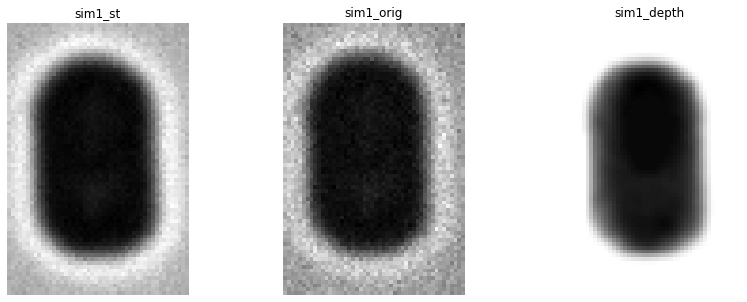

In [43]:
ST_set_save = ST_Simul_Dataset_Save(df_simul)
ST_loader_save = DataLoader(ST_set_save, batch_size=1)

with torch.no_grad():
  for sem, depth, case, idx in tqdm(iter(ST_loader_save)):
    sem = sem.to(device)
    idx = int(idx)
    case = int(case)
    
    fake_ST = models[case](sem)

    model_pred = (fake_ST + 1) * 212 / 2
    model_pred = model_pred.cpu().numpy()[0][0]
    
    sem = (sem + 1)*212
    sem = sem.cpu().numpy()[0][0]
    
    depth = depth.cpu().numpy()[0]
    
    imgname = ['sim1_st', 'sim1_orig', 'sim1_depth']
    imgs = [model_pred, sem, depth]
    plt.figure(figsize=(14, 5))
    for i, img in enumerate(imgs) :
        plt.subplot(1,len(imgs),i+1)
        plt.title(imgname[i])
        plt.axis('off') 
        plt.imshow(img[:,:], cmap='gray')
    
    break

In [45]:
from os.path import join as opj

Depth_dir = f'./processed_data/simulation/Depth'
Simul_dir = f'./processed_data/simulation/SEM'

os.makedirs(Depth_dir, exist_ok=True)
os.makedirs(Simul_dir, exist_ok=True)

ST_set_save = ST_Simul_Dataset_Save(df_simul)
ST_loader_save = DataLoader(ST_set_save, batch_size=1)

with torch.no_grad():
  for sem, depth, case, idx in tqdm(iter(ST_loader_save)):
    sem = sem.to(device)
    idx = int(idx)
    case = int(case)
    
    fake_ST = models[case](sem)

    model_pred = (fake_ST + 1) * 212 / 2
    model_pred = model_pred.cpu().numpy()[0][0]
    
    depth = depth.cpu().numpy()[0]
    
    simulation_save_path = opj(Simul_dir, f'SEM_{case}_{str(idx).zfill(5)}.png')
    depth_save_path = opj(Depth_dir, f'Depth_{case}_{str(idx).zfill(5)}.png')
    
    cv2.imwrite(simulation_save_path, model_pred)
    cv2.imwrite(depth_save_path, depth)

100%|███████████████████████████████████████████████████████████████████████████| 86652/86652 [12:20<00:00, 117.05it/s]
